In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [1]:


# Define the model parameters
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys # The dimension is divided among the heads.  Thus every head key value will be d_k/h= 8
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer # Usually 4* d_model
n = 6  # Number of layers in the encoder stack
batch_size = 64
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1


In [4]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

Data preprocessing is done with Tensorflow because it is cleaner.

In [5]:
# Downloading the data

In [6]:
import gdown

url = f"https://drive.google.com/uc?id=1Lz7Xjx4iwp_OGBOpO2VnzJoiVk20YbmT"
gdown.download(url, None, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Lz7Xjx4iwp_OGBOpO2VnzJoiVk20YbmT
To: /content/english-german-both.pkl
100%|██████████| 29.6M/29.6M [00:00<00:00, 38.4MB/s]


'english-german-both.pkl'

In [7]:
import tensorflow
from random import shuffle
from pickle import load
import numpy as np
from typing import Tuple

class PrepareDataset:
    def __init__(self) -> None:
      self.train_split: float = 0.9  # Ratio of the training data split

    # Fit a tokenizer
    def create_tokenizer(self, dataset: np.ndarray) -> tensorflow.keras.preprocessing.text.Tokenizer:
      tokenizer = tensorflow.keras.preprocessing.text.Tokenizer()
      tokenizer.fit_on_texts(dataset.tolist())  # Convert to list of strings
      return tokenizer

    # Encode and pad the input sequences
    def encode_pad( self, dataset: np.ndarray, tokenizer: tensorflow.keras.preprocessing.text.Tokenizer,
      seq_length: int ) -> tensorflow.Tensor:
      x = tokenizer.texts_to_sequences(dataset.tolist())  # Convert to list of strings
      x = tensorflow.keras.preprocessing.sequence.pad_sequences(x, maxlen=seq_length, padding='post')
      x = tensorflow.convert_to_tensor(x, dtype=tensorflow.int64)
      return x

    def prepare_tokenizer(self, partial_dataset: np.ndarray) -> Tuple[tensorflow.keras.preprocessing.text.Tokenizer, int, int]:
      tokenizer = self.create_tokenizer(partial_dataset)
      vocab_size = len(tokenizer.word_index) + 1
      max_seq_length = max(len(seq.split()) for seq in partial_dataset.tolist())
      return tokenizer, max_seq_length, vocab_size

    def __call__(self, filename: str) -> Tuple[
        tensorflow.Tensor, tensorflow.Tensor, tensorflow.Tensor, tensorflow.Tensor,
        int, int, int, int,
        tensorflow.keras.preprocessing.text.Tokenizer, tensorflow.keras.preprocessing.text.Tokenizer
    ]:
      # Load a clean dataset
      dataset: np.ndarray = load(open(filename, 'rb'))  # Dataset is a numpy.ndarray
      n_sentences = len(dataset)
      dataset[:, 0] = ["<START> " + seq + " <EOS>" for seq in dataset[:, 0]]
      dataset[:, 1] = ["<START> " + seq + " <EOS>" for seq in dataset[:, 1]]

      # Random shuffle the dataset
      shuffle(dataset)

      # Split the dataset into training and validation sets
      train = dataset[:int(n_sentences * self.train_split)]
      val = dataset[int(n_sentences * self.train_split):]

      # Prepare tokenizer for the encoder input
      enc_tokenizer, enc_seq_length, enc_vocab_size = self.prepare_tokenizer(dataset[:, 0])
      dec_tokenizer, dec_seq_length, dec_vocab_size = self.prepare_tokenizer(dataset[:, 1])

      # Encode and pad the training input
      trainX = self.encode_pad(train[:, 0], enc_tokenizer, enc_seq_length)
      trainY = self.encode_pad(train[:, 1], dec_tokenizer, dec_seq_length)

      # Encode and pad the validation input
      valX = self.encode_pad(val[:, 0], enc_tokenizer, enc_seq_length)
      valY = self.encode_pad(val[:, 1], dec_tokenizer, dec_seq_length)

      return (
          trainX, trainY, valX, valY,
          enc_seq_length, dec_seq_length,
          enc_vocab_size, dec_vocab_size,
          enc_tokenizer, dec_tokenizer
      )


In [8]:
dataset_manipulator=PrepareDataset()
trainX, trainY,valX, valY, enc_seq_len, dec_seq_len, enc_vocab_size, dec_vocab_size, enc_tokenizer,dec_tokenizer = dataset_manipulator('english-german-both.pkl')
trainX = torch.tensor(trainX.numpy())  # Convert to PyTorch tensor
trainY = torch.tensor(trainY.numpy())  # Convert to PyTorch tensor

valX = torch.tensor(valX.numpy())      # Convert to PyTorch tensor
valY = torch.tensor(valY.numpy())      # Convert to PyTorch tensor

train_dataloader= torch.utils.data.DataLoader(torch.utils.data.TensorDataset(trainX ,trainY), batch_size=batch_size, shuffle=True)
val_dataloader= torch.utils.data.DataLoader(torch.utils.data.TensorDataset(valX, valY), batch_size=batch_size, shuffle=True)

# Model

## Multi Head Attention (MHA):

 Steps in MHA</br>

 1) Transformation into Q,K,V matrices. </br>

 2) Subsequent division of last dimension( embedding dimension) into n_heads

 3) self attention in each head. Note: Can be computed in a single matrix mulitplication

4) Combining the heads back

5) Get final output by mulitplying the value matrix.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

class MultiHeadAttention(nn.Module):
  def __init__(self, h: int, d_k: int, d_v: int, d_model: int) -> None:
    """
    Initializes the MultiHeadAttention module.

    Args:
        h (int): Number of attention heads.
        d_k (int): Dimensionality of keys and queries.
        d_v (int): Dimensionality of values.
        d_model (int): Dimensionality of the model.
    """
    super().__init__()
    self.heads = h
    self.d_k = d_k
    self.d_v = d_v
    self.d_model = d_model

    # Linear transformations for queries, keys, values, and the output
    self.W_q = nn.Linear(d_model, d_k)
    self.W_k = nn.Linear(d_model, d_k)
    self.W_v = nn.Linear(d_model, d_v)
    self.W_o = nn.Linear(d_v, d_model)

  def forward( self,  queries: torch.Tensor, keys: torch.Tensor,
    values: torch.Tensor,  mask: Optional[torch.Tensor] = None ) -> torch.Tensor:
    """
    Performs the forward pass of the multi-head attention mechanism.

    Args:
        queries (torch.Tensor): Query tensor of shape (batch_size, seq_length, d_model).
        keys (torch.Tensor): Key tensor of shape (batch_size, seq_length, d_model).
        values (torch.Tensor): Value tensor of shape (batch_size, seq_length, d_model).
        mask (Optional[torch.Tensor]): Mask tensor of shape (batch_size, seq_length, seq_length) or None.

    Returns:
        torch.Tensor: Output tensor of shape (batch_size, seq_length, d_model).
    """
    # 1. Linear projections for queries, keys, and values

    q = self.W_q(queries)
    k = self.W_k(keys)
    v = self.W_v(values)

    # 2. Reshape into multi-head format
    q = self.reshape_tensor(q)
    k = self.reshape_tensor(k)
    v = self.reshape_tensor(v)
    # 3. Compute scaled dot-product attention
    wei = self.attention(q, k, v, self.d_k, mask)

    # 4. Reshape back to original format

    wei = self.reshape_tensor(wei, reverse=True)

    # 5. Apply final linear transformation
    return self.W_o(wei)

  def reshape_tensor(self, x: torch.Tensor, reverse: bool = False) -> torch.Tensor:
    """
    Reshapes the tensor for multi-head attention computation.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, seq_length, d_model).
        reverse (bool): If True, reshapes back to the original format.

    Returns:
        torch.Tensor: Reshaped tensor.

    Note: Transpose has to be applied here- to turn [B,T,H,h/d_k]==> [B,H,T,h/d_k].
          Because during the attention two dimensions has to participate, namely time/token dimension and embedding dimension (not the head dimension).
          So transpose is necessary here.
    """
    if not reverse:
      b, t, c = x.size()
      return x.view(b, t, self.heads, c // self.heads).transpose(1, 2)
    else:
      x = x.transpose(1, 2)
      return x.contiguous().view(x.shape[0], x.shape[1], self.d_v)

  def attention(self,  q: torch.Tensor, k: torch.Tensor, v: torch.Tensor,d_k: int, mask: Optional[torch.Tensor] = None
  ) -> torch.Tensor:
      """
      Computes the scaled dot-product attention.

      Args:
          q (torch.Tensor): Query tensor of shape (batch_size, heads, seq_length, d_k).
          k (torch.Tensor): Key tensor of shape (batch_size, heads, seq_length, d_k).
          v (torch.Tensor): Value tensor of shape (batch_size, heads, seq_length, d_v).
          d_k (int): Dimensionality of keys and queries.
          mask (Optional[torch.Tensor]): Mask tensor of shape (batch_size, seq_length, seq_length) or None.

      Returns:
          torch.Tensor: Output tensor of shape (batch_size, heads, seq_length, d_v).
      """
      wei = q @ k.transpose(-2, -1) * d_k**-0.5  # (B, H, T, D_k) @ (B, H, D_k, T) -> (B, H, T, T)
      if mask is not None:
          wei += -1e9 * mask  # Large negative values give zero for softmax,
      wei = F.softmax(wei, dim=-1)  # Normalize attention scores
      return wei @ v  # (B, H, T, T) @ (B, H, T, D_v) -> (B, H, T, D_v)


## FFNN and Layernorm


FFNN is applied at the end of each encoder and decoder block. FFNN layer is composed of two linear opeartions. This layer changes the last dimension to d_ff an then takes it back. This layer has a ReLU layer inbetween, but not after.

In [10]:
class Feed_Forward(nn.Module):
  def __init__(self, d_model : int, d_ff: int)-> None:
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(d_model, d_ff),
      nn.ReLU(),
      nn.Linear(d_ff, d_model),
    )
  def forward(self,x:torch.Tensor)-> torch.Tensor:
    return self.net(x)


Layernorm is applied at the end of each sublayer. </br>

## Positional Encoding

Positional Encoding table is precomputed.

1) Number of rows is determined by max sequence length (This is extracted from the training set).

2) Number of columns is embedding dimension or model_dimension.

In [11]:
class PositionalEncoding(nn.Module):
  def __init__(self, model_dimension: int, expected_max_sequence_length: int)-> None:
    super().__init__()
    position_id = torch.arange(expected_max_sequence_length).unsqueeze(1)
    frequencies = 10000 ** (-torch.arange(0, model_dimension, 2, dtype=torch.float) / model_dimension)

    # Precompute the positional encodings
    positional_encodings_table = torch.zeros(expected_max_sequence_length, model_dimension)
    positional_encodings_table[:, 0::2] = torch.sin(position_id * frequencies)
    positional_encodings_table[:, 1::2] = torch.cos(position_id * frequencies)

    # Save the encodings as a non-trainable buffer
    self.register_buffer('positional_encodings_table', positional_encodings_table)

  def forward(self, embeddings_batch: torch.Tensor)-> torch.Tensor:

    assert embeddings_batch.shape[-1] == self.positional_encodings_table.size(1), \
      f"Model dimension mismatch: {embeddings_batch.shape[-1]} != {self.positional_encodings_table.size(1)}"

    # Select and return positional encodings matching the sequence length
    return self.positional_encodings_table[:embeddings_batch.size(1)]


## Encoder

#### Encoder Block

x------------------------------------------------------x</br>
|&nbsp; &nbsp; &nbsp;    &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;     + &nbsp; &nbsp; =&nbsp; &nbsp; &nbsp; layernorm(x)------------------------------layernorm(x) </br>
x->layernorm(x)->MHA(x)->dropout(x)    &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;     |                          &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;   +  = output</br>
     &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;                                       FFNN(x)-- ReLU(x)--FNNN(x) --- dropout(x)

In [12]:
from typing import Optional

class EncoderBlock(nn.Module):
  def __init__(self, h: int, d_k: int, d_v: int, d_model: int, rate: float, d_ff: int= d_ff) -> None:
    super().__init__()

    self.MHA = MultiHeadAttention(h, d_k, d_v, d_model)

    self.dropout1 = nn.Dropout(rate)
    self.dropout2 = nn.Dropout(rate)

    self.layernorm1 = nn.LayerNorm(d_model)
    self.layernorm2 = nn.LayerNorm(d_model)

    self.Feed_Forward = Feed_Forward(d_model, d_ff)

  def forward(self, x: torch.Tensor, padding_mask: Optional[torch.Tensor] = None ) -> torch.Tensor:

    x_sideline = self.layernorm1(x)

    x = x + self.dropout1(self.MHA(x_sideline, x_sideline, x_sideline, padding_mask))

    x_sideline1 = self.layernorm2(x)  # mha -> dropout -> residual -> layer norm

    x = x + self.dropout2(self.Feed_Forward(x_sideline1))  # FFNN -> dropout -> residual -> layer norm

    return x


Encoder block is repeated 8 (n_layers) times.
Nt: Dropout layer is added after positional encoding

### Encoder

In [13]:
class Encoder(nn.Module):
  def __init__(self, vocab_size: int, max_length: int, d_model: int, h: int, d_k: int, d_v: int, d_ff: int, n_layers: int, rate: float) -> None:
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.positional_encoding = PositionalEncoding(d_model, max_length)
    self.dropout = nn.Dropout(rate)

    self.layers = nn.ModuleList([EncoderBlock(h, d_k, d_v, d_model, rate) for _ in range(n_layers)])

  def forward(self, sentence: torch.Tensor, padding_mask: Optional[torch.Tensor]=None) -> torch.Tensor:
    x = self.embedding(sentence)
    x = x + self.positional_encoding(x)
    x = self.dropout(x)
    for layer in self.layers:
        x = layer(x, padding_mask)
    return x


## Decoder

So, the structure goes as below.
 norm-> MHA -> dropout-> residual norm
 MHA2(Cross attention) -> dropout -> residual norm
 FF -> dropout -> residual norm.

 **Note**:

 1) Layer norms are applied before sublayers rather than after.

 2) Padding mask is necessary for every attention computation. But, look ahead mask is used only during decoder self attention
*   Encoder has sentence which needs to be translated. So encoder should have access to all the tokenns in a sentence.
*   Decoder translates the sentence. That is why it should not have access future words during training. That is why look aheed mask is used in a decoder not in encoder.
*  The Look ahead mask is not used during cross attention. This is because keys are provided by the encoder and it does not use this mask
* The padding mask for cross attention is constructed from the encoder input.

In the code look_ahead mask already has the paddin mask engrained with it.



In [14]:
from typing import Optional

class DecoderBlock(nn.Module):
  def __init__(self, h: int, d_k: int, d_v: int, d_model: int, d_ff: int, rate: float) -> None:
    super().__init__()
    self.MHA = MultiHeadAttention(h, d_k, d_v, d_model)
    self.MHA2 = MultiHeadAttention(h, d_k, d_v, d_model)

    # It is not necessary to define dropout layers mulitple times. It is stateless.
    self.dropout3 = nn.Dropout(rate)
    self.dropout2 = nn.Dropout(rate)
    self.dropout1 = nn.Dropout(rate)

    # Layernorm have learned parameters(Gamma and beta)
    self.add_norm = nn.LayerNorm(d_model)
    self.add_norm2 = nn.LayerNorm(d_model)
    self.add_norm3 = nn.LayerNorm(d_model)

    self.Feed_Forward = Feed_Forward(d_model, d_ff)

  def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, padding_mask: Optional[torch.Tensor] = None, look_ahead_mask: Optional[torch.Tensor] = None) -> torch.Tensor:

    x_sideline = self.add_norm(x)
    x = x + self.dropout1(self.MHA(x_sideline, x_sideline, x_sideline, look_ahead_mask))

    x_sideline1 = self.add_norm2(x)
# Encoder output is used because this is cross-attention. Padding mask is constructed from encoder input
    x = x + self.dropout2(self.MHA2(x_sideline1, encoder_output, encoder_output, padding_mask))


    x_sideline2 = self.add_norm3(x)
    x = x + self.dropout3(self.Feed_Forward(x_sideline2))
    return x


In [15]:
from typing import Optional

class Decoder(nn.Module):
  def __init__(self, vocab_size: int, max_length: int, d_model: int, h: int, d_k: int, d_v: int, d_ff: int, n_layers: int, rate: float) -> None:
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, d_model)

    self.positional_encoding = PositionalEncoding(d_model, max_length)
    self.dropout = nn.Dropout(rate)

    self.layers = nn.ModuleList([DecoderBlock(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n_layers)])

  def forward(self, decoder_input: torch.Tensor, encoder_output: torch.Tensor, lookahead_mask: Optional[torch.Tensor], padding_mask: Optional[torch.Tensor]) -> torch.Tensor:
    x = self.embedding(decoder_input)

    x = x + self.positional_encoding(x)
    x = self.dropout(x)

    for layer in self.layers:

        x = layer(x, encoder_output, padding_mask, lookahead_mask)
    return x


## Transformer

In [16]:
from typing import Optional, Union, Type

class Transformer(nn.Module):
  def __init__(self, enc_vocab_size: int, dec_vocab_size: int, enc_seq_len: int, dec_seq_len: int,
               d_model: int, h: int, d_k: int, d_v: int, d_ff: int, n_layers: int, rate: float) -> None:
    super().__init__()

    self.encoder = Encoder(enc_vocab_size, enc_seq_len, d_model, h, d_k, d_v, d_ff, n_layers, rate)
    self.decoder = Decoder(dec_vocab_size, dec_seq_len, d_model, h, d_k, d_v, d_ff, n_layers, rate)
    self.model_output = nn.Linear(d_model, dec_vocab_size)

    self.init_weights() # Xavier Initialization

  def forward(self, encoder_input: torch.Tensor, decoder_input: torch.Tensor) -> torch.Tensor:
    # Creating padding mask. This will remove padded tokens out of contibution during attention.
    padding_mask_enc = self.padding_mask(encoder_input)
    padding_mask_dec = self.padding_mask(decoder_input)

    lookahead_mask_dec = self.look_ahead_mask(decoder_input.shape[1])
    lookahead_mask_dec = torch.maximum(lookahead_mask_dec, padding_mask_dec)

    encoder_output = self.encoder(encoder_input, padding_mask_enc)
    decoder_output = self.decoder(decoder_input, encoder_output, lookahead_mask_dec, padding_mask_enc)
    return self.model_output(decoder_output)


  def padding_mask(self, x: torch.Tensor) -> torch.Tensor:
    return (x == 0).float().unsqueeze(1).unsqueeze(1) # Shape =[Batch,1,1,seq_length]. This will broadcast during attention to [Batch,heads,seq_length,seq_length].

  def look_ahead_mask(self, shape: int) -> torch.Tensor:
    x = torch.tril(torch.ones((shape, shape), device=device))
    return x.type(torch.float32)

  def init_weights(self) -> None:
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Training

## Functions

In [17]:
import torch
import torch.nn.functional as F
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def loss_fcn(target, prediction):
  padding_mask = (target != 0).float()
  loss = F.cross_entropy(prediction, target, reduction='none',label_smoothing=0.1) * padding_mask # reduction none returns values every seq length. Otherwise will return a mean scalar.
  # Compute the mean loss over the unmasked values
  return loss.sum() / padding_mask.sum()

def accuracy_fcn(target, prediction):
    padding_mask = (target != 0)
    accuracy = (target == torch.argmax(prediction, dim=2))
    accuracy = padding_mask & accuracy # And operation. If padding mask is 0 ( padded accuracy is not counted)
    padding_mask = padding_mask.float()
    accuracy = accuracy.float()
    # Compute the mean accuracy over the unmasked values
    return accuracy.sum() / padding_mask.sum()

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def BLEU(reference, candidate, pad_token=0):
    # Smoothing function (using method6)
    smooth_fn = SmoothingFunction().method4
    eos = dec_tokenizer.word_index['eos']

    # Remove padding and <eos> tokens from reference and candidate sequences
    candidate = [[word for word in sent if word not in [pad_token, eos]] for sent in candidate]
    reference = [[word for word in sent if word not in [pad_token, eos]] for sent in reference]

    bleu_score = 0
    bleu_scores = []  # Store individual BLEU scores for debugging

    # Compute BLEU score for each sentence in the batch
    for cand, ref in zip(candidate, reference):
      for i in range(len(cand)):
        cand[i] = cand[i].item()
      for i in range(len(ref)):
        ref[i] = ref[i].item()
      score = sentence_bleu([ref],cand, smoothing_function=smooth_fn)
      bleu_scores.append(score)
      bleu_score += score

    # Return average BLEU score over all sentences in the batch
    return bleu_score / len(candidate)



In [18]:
from torch.optim.lr_scheduler import _LRScheduler
import math

class LRScheduler(_LRScheduler):
  def __init__(self, optimizer, d_model, warmup_steps=150, last_epoch=-1):
    self.d_model = d_model
    self.warmup_steps = warmup_steps
    super(LRScheduler, self).__init__(optimizer, last_epoch)

  def get_lr(self):
  # Get the current step number
    step_num = max(1, self._step_count)

    # Linearly increasing the learning rate for the first warmup_steps, and decreasing it thereafter
    arg1 = step_num ** -0.5
    arg2 = step_num * (self.warmup_steps ** -1.5)

    # Compute the learning rate according to the schedule
    lr = (self.d_model ** -0.5) * min(arg1, arg2)

    return [lr for _ in self.optimizer.param_groups]

class NoWarmupLRScheduler(_LRScheduler):
    def __init__(self, optimizer, initial_lr=5e-4, decay_epoch=10, decay_factor=0.1, last_epoch=-1):
        self.initial_lr = initial_lr
        self.decay_epoch = decay_epoch
        self.decay_factor = decay_factor
        super(NoWarmupLRScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # Get the current epoch
        epoch = self.last_epoch + 1

        # If we are past the decay_epoch, apply the decay factor
        if epoch >= self.decay_epoch:
            lr = self.initial_lr * (self.decay_factor ** (epoch - self.decay_epoch + 1))
        else:
            lr = self.initial_lr

        # Return the updated learning rates for all parameter groups
        return [lr for _ in self.optimizer.param_groups]


In [42]:
import matplotlib.pyplot as plt
import torch

class Model_worker:
  def __init__(self, model, scheduler, optimizer, loss_fn, accuracy_fn, device, dec_vocab_size):
    self.model = model
    self.scheduler = scheduler(optimizer)
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.accuracy_fn = accuracy_fn
    self.device = device
    self.dec_vocab_size = dec_vocab_size
    self.epochs_done = 0

  def train_epoch(self, train_dataloader, BLEU):
    self.model.train()
    loss_list = []
    bleu_list = []

    for step, (i, j) in enumerate(train_dataloader):
      i, j = i.to(self.device), j.to(self.device)
      dec_input = j[:, :-1]
      target = j[:, 1:]

      # Forward pass
      prediction = self.model(i, dec_input)
      loss = self.loss_fn(target.reshape(-1), prediction.reshape(-1, self.dec_vocab_size))
      accuracy = self.accuracy_fn(target, prediction)

      # Backpropagation and optimization
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      # Store loss and BLEU score
      loss_list.append(loss.item())
      bleu_list.append(BLEU(target, prediction.argmax(dim=-1)))

      # Print every 10 steps
      print( f"\rEpoch: {self.epochs_done+1} | Step {step} | Average Loss: {sum(loss_list) / len(loss_list):.5f} Average BLEU Score: {sum(bleu_list) / len(bleu_list):.5f}",end="")

    # Plot training loss
    if PLOT:
      plt.plot(loss_list)
      plt.xlabel('batch')
      plt.ylabel('Loss')
      plt.title('Loss vs batch')
      plt.show()

    self.scheduler.step()
    self.epochs_done += 1
    return sum(loss_list) / len(loss_list), sum(bleu_list) / len(bleu_list)

  def validate(self, val_dataloader, BLEU):
    self.model.eval()
    val_loss_list = []
    val_bleu_list = []

    with torch.no_grad():
      for i, j in val_dataloader:
        i, j = i.to(self.device), j.to(self.device)
        dec_input = j[:, :-1]
        target = j[:, 1:]

        # Forward pass
        prediction = self.model(i, dec_input)

        # Calculate validation loss and BLEU score
        val_loss = self.loss_fn(target.reshape(-1), prediction.reshape(-1, self.dec_vocab_size))
        val_bleu = BLEU(target, prediction.argmax(dim=-1))

        val_loss_list.append(val_loss.item())
        val_bleu_list.append(val_bleu)

    return sum(val_loss_list) / len(val_loss_list), sum(val_bleu_list) / len(val_bleu_list)

  def train_and_validate(self, train_dataloader, val_dataloader, BLEU, num_epochs):
    train_lossi = []
    train_bleui = []
    val_lossi= []
    val_bleui=[]
    val_loss, val_bleu = self.validate(val_dataloader, BLEU)
    print(f"Validation Loss before training: {val_loss:.5f}")

    for epoch in range(num_epochs):
      # print(f"Epoch {epoch}")
      # Training
      avg_loss, avg_bleu = self.train_epoch(train_dataloader, BLEU)

      train_lossi.append(avg_loss)
      train_bleui.append(avg_bleu)

      # print(f"Epoch {epoch} | Average Loss: {avg_loss}")
      # print(f"Epoch {epoch} | Average BLEU Score: {avg_bleu}")

      # Validation
      val_loss, val_bleu = self.validate(val_dataloader, BLEU)
      print(f"\n Validation Loss: {val_loss:.5f} |  Validation BLEU Score {val_bleu:.5f}")
      val_lossi.append(val_loss)
      val_bleui.append(val_bleu)

    return train_lossi, train_bleui, val_lossi, val_bleui


  def inference(self, eng_sentence, enc_seq_len, dec_seq_len, enc_tokenizer, dec_tokenizer,model= None):
    if model== None:
      model=self.model

    enc_token = enc_tokenizer.texts_to_sequences(["<START>" + eng_sentence + "<EOS>"])
    enc_input = torch.tensor(enc_token, dtype=torch.int32).to(device)

    # Initialize the decoder sequence with <START> token
    dec_start = torch.tensor(dec_tokenizer.texts_to_sequences(['<START>']), dtype=torch.int64).to(device)
    dec_end = dec_tokenizer.texts_to_sequences(['<EOS>'])[0][0]  # Extract the EOS token ID

    model.eval()
    for _ in range(dec_seq_len):
      with torch.no_grad():
        prediction = model(enc_input, dec_start)

          # Select the token with the highest probability
      logits = prediction[0, -1]

      # Apply softmax to convert logits to probabilities
      probabilities = torch.softmax(logits, dim=-1)

# Sample a token from the probability distribution
      predicted_token = torch.multinomial(probabilities, num_samples=1).item()

      # Break if <EOS> is reached
      if predicted_token == dec_end:
          break

          # Append predicted token to the decoder input
      next_token = torch.tensor([[predicted_token]], dtype=torch.int64).to(device)
      dec_start = torch.cat([dec_start, next_token], dim=1)
    model.train()

    # Convert decoded sequence back to text
    decoded_sequence = dec_tokenizer.sequences_to_texts(dec_start.cpu().numpy())
    return decoded_sequence[0][1:]  # Return the complete translation
  # Removing the start token


## Training


In [20]:
PLOT= False # Plots loss after every epoch
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [21]:
num_epochs=15

In [43]:
# model=Transformer(enc_vocab_size,dec_vocab_size,enc_seq_len,dec_seq_len,d_model,h,d_k,d_v,d_ff,n,dropout_rate)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-9, betas=(0.9, 0.98), eps=1e-9)
model_worker = Model_worker(model, NoWarmupLRScheduler, optimizer, loss_fcn, accuracy_fcn, device, dec_vocab_size)

In [23]:
train_loss,train_bleu,val_loss,val_bleu=model_worker.train_and_validate(train_dataloader, val_dataloader, BLEU, num_epochs)

Validation Loss before training: 10.06681
Epoch: 1 | Step 140 | Average Loss: 6.15540 Average BLEU Score: 0.02991
 Validation Loss: 3.93827 |  Validation BLEU Score 0.09138
Epoch: 2 | Step 140 | Average Loss: 3.48294 Average BLEU Score: 0.10573
 Validation Loss: 2.92290 |  Validation BLEU Score 0.15321
Epoch: 3 | Step 140 | Average Loss: 2.66662 Average BLEU Score: 0.16362
 Validation Loss: 2.48720 |  Validation BLEU Score 0.20927
Epoch: 4 | Step 140 | Average Loss: 2.17706 Average BLEU Score: 0.21409
 Validation Loss: 2.21670 |  Validation BLEU Score 0.20121
Epoch: 5 | Step 140 | Average Loss: 1.85875 Average BLEU Score: 0.24033
 Validation Loss: 2.06381 |  Validation BLEU Score 0.22862
Epoch: 6 | Step 140 | Average Loss: 1.65694 Average BLEU Score: 0.27069
 Validation Loss: 1.93386 |  Validation BLEU Score 0.28054
Epoch: 7 | Step 140 | Average Loss: 1.53020 Average BLEU Score: 0.29926
 Validation Loss: 1.85418 |  Validation BLEU Score 0.29613
Epoch: 8 | Step 140 | Average Loss: 1.442

# Plotting

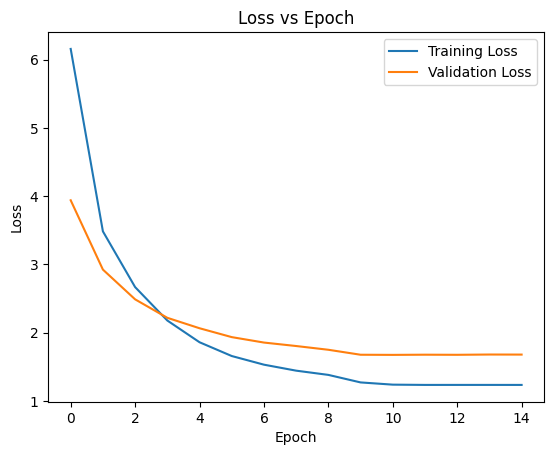

In [24]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.plot(val_bleu, label='Validation BLEU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

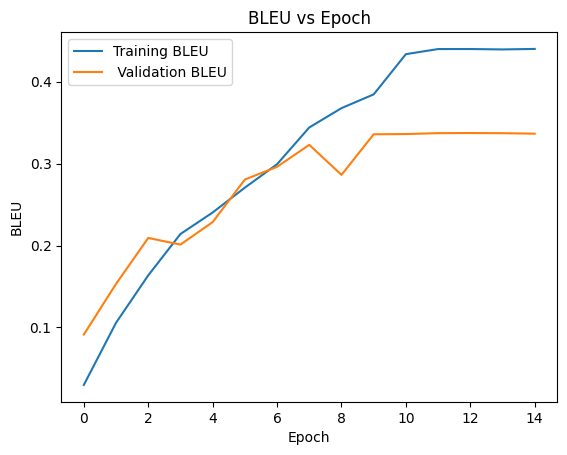

In [25]:
plt.plot(train_bleu, label='Training BLEU')
plt.plot(val_bleu, label=' Validation BLEU')
# plt.plot(val_bleu, label='Validation BLEU')
plt.xlabel('Epoch')
plt.ylabel('BLEU')
plt.title('BLEU vs Epoch')
plt.legend()
plt.show()

# Inference

In [ ]:
model_worker.inference('i like both',enc_seq_len,dec_seq_len,enc_tokenizer,dec_tokenizer)